In [1]:
# import necessary module
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

import seaborn as sns
import scipy
from array_response import *
import itertools 

from IPython.display import Image


### Parameters declaration

Declare parameters needed for channel realization

In [2]:
Ns = 1 # number of streams

Nc = 2 # number of cluster
Nray = 1 # number of rays in each cluster

Nt = 64 # number of transmit antennas
Nr = 16 # number of receive antennas

angle_sigma = 10/180*np.pi # standard deviation of the angles in azimuth and elevation both of Rx and Tx

gamma = np.sqrt((Nt*Nr)/(Nc*Nray))
realization = 1000 # equivalent to number of taking sample
count = 0

eps = 0.1 # 20dB isolation
sigma = np.sqrt(8/(1+eps**2)) # according to the normalization condition of H


### Channel Realization

Realize channel H for Dual-Polarized antenna array

In [3]:
H_pol = np.zeros((2*Nr,2*Nt,realization),dtype=complex)
At = np.zeros((Nt,Nc*Nray,realization),dtype=complex)
Ar = np.zeros((Nr,Nc*Nray,realization),dtype=complex)
alpha_hh = np.zeros((Nc*Nray,realization),dtype=complex)
alpha_hv = np.zeros((Nc*Nray,realization),dtype=complex)
alpha_vh = np.zeros((Nc*Nray,realization),dtype=complex)
alpha_vv = np.zeros((Nc*Nray,realization),dtype=complex)

AoD = np.zeros((2,Nc*Nray),dtype=complex)
AoA = np.zeros((2,Nc*Nray),dtype=complex)

H = np.zeros((2*Nr,2*Nt,realization),dtype=complex)
azi_rot = np.random.uniform(0,2*np.pi,realization)
ele_rot = np.random.uniform(0,np.pi/2,realization) # Why PI/2 ??
R = np.array([[np.cos(ele_rot)*np.cos(azi_rot),np.sin(ele_rot)],[-np.sin(ele_rot)*np.cos(azi_rot),np.cos(ele_rot)]]) # rotation matrix

for reali in range(realization):
    for c in range(1,Nc+1):
        AoD_azi_m = np.random.uniform(0,2*np.pi,1) # Mean Angle of Departure _ azimuth
        AoD_ele_m = np.random.uniform(0,np.pi,1) # Mean Angle of Departure _ elevation
        AoA_azi_m = np.random.uniform(0,2*np.pi,1) # Mean Angle of Arrival_ azimuth
        AoA_ele_m = np.random.uniform(0,np.pi,1) # Mean Angle of Arrival_ elevation
        AoD[0,(c-1)*Nray:Nray*c] = np.random.laplace(AoD_azi_m, angle_sigma, (1,Nray))
        AoD[1,(c-1)*Nray:Nray*c] = np.random.laplace(AoD_ele_m, angle_sigma, (1,Nray))
        AoA[0,(c-1)*Nray:Nray*c] = np.random.laplace(AoA_azi_m, angle_sigma, (1,Nray))
        AoA[1,(c-1)*Nray:Nray*c] = np.random.laplace(AoA_ele_m, angle_sigma, (1,Nray))
    for j in range(Nc*Nray):
        At[:,j,reali] = array_response(AoD[0,j],AoD[1,j],Nt) # UPA array response
        Ar[:,j,reali] = array_response(AoA[0,j],AoA[1,j],Nr)
        var_hh = ((sigma**2)*(np.cos(AoD[0,j])**2)*(np.cos(AoA[0,j])**2)).real
        var_hv = ((eps**2)*(sigma**2)*(np.cos(AoD[1,j])**2)*(np.cos(AoA[0,j])**2)).real
        var_vh = ((eps**2)*(sigma**2)*(np.cos(AoD[0,j])**2)*(np.cos(AoA[1,j])**2)).real
        var_vv = ((sigma**2)*(np.cos(AoD[1,j])**2)*(np.cos(AoA[1,j])**2)).real
        alpha_hh[j,reali] = np.random.normal(0, np.sqrt(var_hh/2)) + 1j*np.random.normal(0, np.sqrt(var_hh/2))
        alpha_hv[j,reali] = np.random.normal(0, np.sqrt(var_hv/2)) + 1j*np.random.normal(0, np.sqrt(var_hv/2))
        alpha_vh[j,reali] = np.random.normal(0, np.sqrt(var_vh/2)) + 1j*np.random.normal(0, np.sqrt(var_vh/2))
        alpha_vv[j,reali] = np.random.normal(0, np.sqrt(var_vv/2)) + 1j*np.random.normal(0, np.sqrt(var_vv/2))
        alpha = np.vstack((np.hstack((alpha_hh[j,reali],alpha_hv[j,reali])),np.hstack((alpha_vh[j,reali],alpha_vv[j,reali]))))
        H_pol[:,:,reali] = H_pol[:,:,reali] + np.kron(alpha,Ar[:,[j],reali]@At[:,[j],reali].conj().T)
    H_pol[:,:,reali] = gamma* H_pol[:,:,reali]
    H[:,:,reali] = (np.kron(R[:,:,reali],np.eye(Nr)))@H_pol[:,:,reali]
    H[:,:,reali] = np.sqrt(4/3)* H[:,:,reali]


### Check normalized condition

In [4]:
channel_fro_1 = np.zeros(realization)
for reali in range(realization):
    channel_fro_1[reali] = np.linalg.norm(H_pol[:,:,reali],'fro')
print("4*Nt*Nr =", 4*Nt*Nr , "   Frobenius norm H pol=", np.mean(channel_fro_1**2))

4*Nt*Nr = 4096    Frobenius norm H pol= 4195.6602065


In [5]:
channel_fro_2 = np.zeros(realization)
for reali in range(realization):
    channel_fro_2[reali] = np.linalg.norm(H[:,:,reali],'fro')
print("4*Nt*Nr =", 4*Nt*Nr , "   Frobenius norm =", np.mean(channel_fro_2**2))

4*Nt*Nr = 4096    Frobenius norm = 4133.0281459


### Joint Horizontal/Vertical Beamformer Selection

| hori_tx | hori_rx | verti_tx | verti_rx |
|:--------|--------|--------:|:---------:|

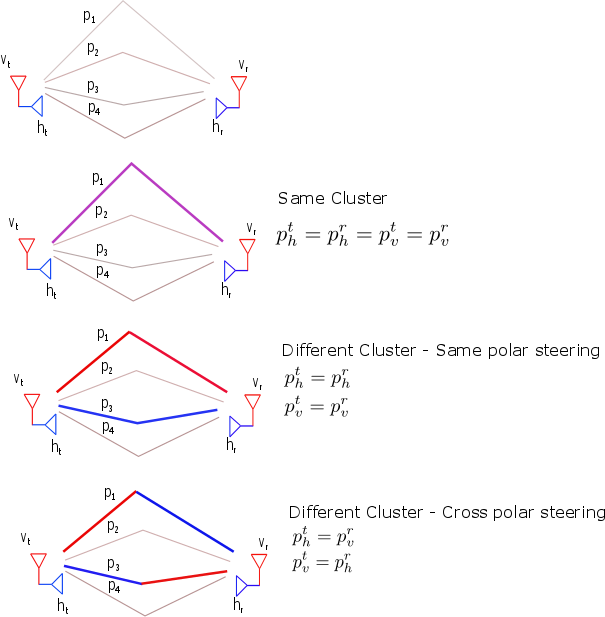

In [6]:
Image("img/cluster.png")

__path gain of each combination__

In [7]:
cluster = np.arange(Nc)
print(cluster)
c = list(itertools.combinations(cluster, 2))
num_path = (2*Nc-1)*Nc
path_combi = np.zeros((num_path,4),dtype=int)

print(path_combi.shape)
path_combi[0:Nc,:]=np.arange(Nc).reshape(Nc,1).repeat(4,axis=1)

count = 0
for i in range(int(Nc*(Nc-1)/2)):
    path_combi[Nc+4*i,:] = np.array([c[count][0],c[count][0],c[count][1],c[count][1]])
    path_combi[Nc+4*i+1,:] = np.array([c[count][1],c[count][1],c[count][0],c[count][0]])
    path_combi[Nc+4*i+2,:] = np.array([c[count][0],c[count][1],c[count][1],c[count][0]])
    path_combi[Nc+4*i+3,:] = np.array([c[count][1],c[count][0],c[count][0],c[count][1]])
    count = count+1
# print(path_combi[0:10,:])
path_gain = np.zeros((num_path,realization)) # 2 to save the position and maximum value
for reali in range(realization):
    for combi in range(num_path):
        path_gain[combi,reali] =\
        (np.abs\
         ((np.cos(ele_rot[reali])*np.cos(azi_rot[reali])*alpha_hh[path_combi[combi,0],reali]+np.sin(ele_rot[reali])*alpha_vh[path_combi[combi,0],reali])*(path_combi[combi,0]==path_combi[combi,1])+\
         (np.cos(ele_rot[reali])*np.cos(azi_rot[reali])*alpha_hv[path_combi[combi,2],reali]+np.sin(ele_rot[reali])*alpha_vv[path_combi[combi,2],reali])*(path_combi[combi,2]==path_combi[combi,1])+\
         (-np.sin(ele_rot[reali])*np.cos(azi_rot[reali])*alpha_hh[path_combi[combi,0],reali]+np.cos(ele_rot[reali])*alpha_vh[path_combi[combi,0],reali])*(path_combi[combi,0]==path_combi[combi,3])+\
         (-np.sin(ele_rot[reali])*np.cos(azi_rot[reali])*alpha_hv[path_combi[combi,2],reali]+np.sin(ele_rot[reali])*alpha_vv[path_combi[combi,2],reali])*(path_combi[combi,2]==path_combi[combi,3])
         ))**2


[0 1]
(6, 4)


In [8]:
path_gain.shape

(6, 1000)

__Check maximum gain from combination of path in each realization__

In [9]:
index = np.zeros(realization,dtype=int)
for reali in range(realization):
    index[reali] = np.argmax(path_gain[:,reali])
    #print(path_gain[index,test])

In [10]:
print(path_combi)

[[0 0 0 0]
 [1 1 1 1]
 [0 0 1 1]
 [1 1 0 0]
 [0 1 1 0]
 [1 0 0 1]]


In [11]:
cross_index =  []
samepolar_index = []
count = Nc-1
while (count<num_path-4):
    cross_index.extend([count+3,count+4])
    samepolar_index.extend([count+1,count+2])
    count = count + 4
cross_index = np.array(cross_index)
samepolar_index = np.array(samepolar_index)
sameclus_index = np.arange(0,Nc)
print(cross_index)
print(samepolar_index)
print(sameclus_index)

[4 5]
[2 3]
[0 1]


In [12]:
print(cross_index)
print(cross_index.shape)
print(path_combi[index[1]])

[4 5]
(2,)
[1 1 1 1]


In [13]:
cross_index_in = np.isin(index, cross_index)
# print(cross_index_in)
print('Number of Cross Index chosen in 1000 realization: ',sum(cross_index_in))

Number of Cross Index chosen in 1000 realization:  113


In [14]:
diff_clus_index = np.arange(Nc,num_path)
diff_clus_index_in = np.isin(index, diff_clus_index)
# print(diff_clus_index_in)
print('Numver of Different Cluster chosen in 1000 realization: ',sum(diff_clus_index_in))

Numver of Different Cluster chosen in 1000 realization:  271


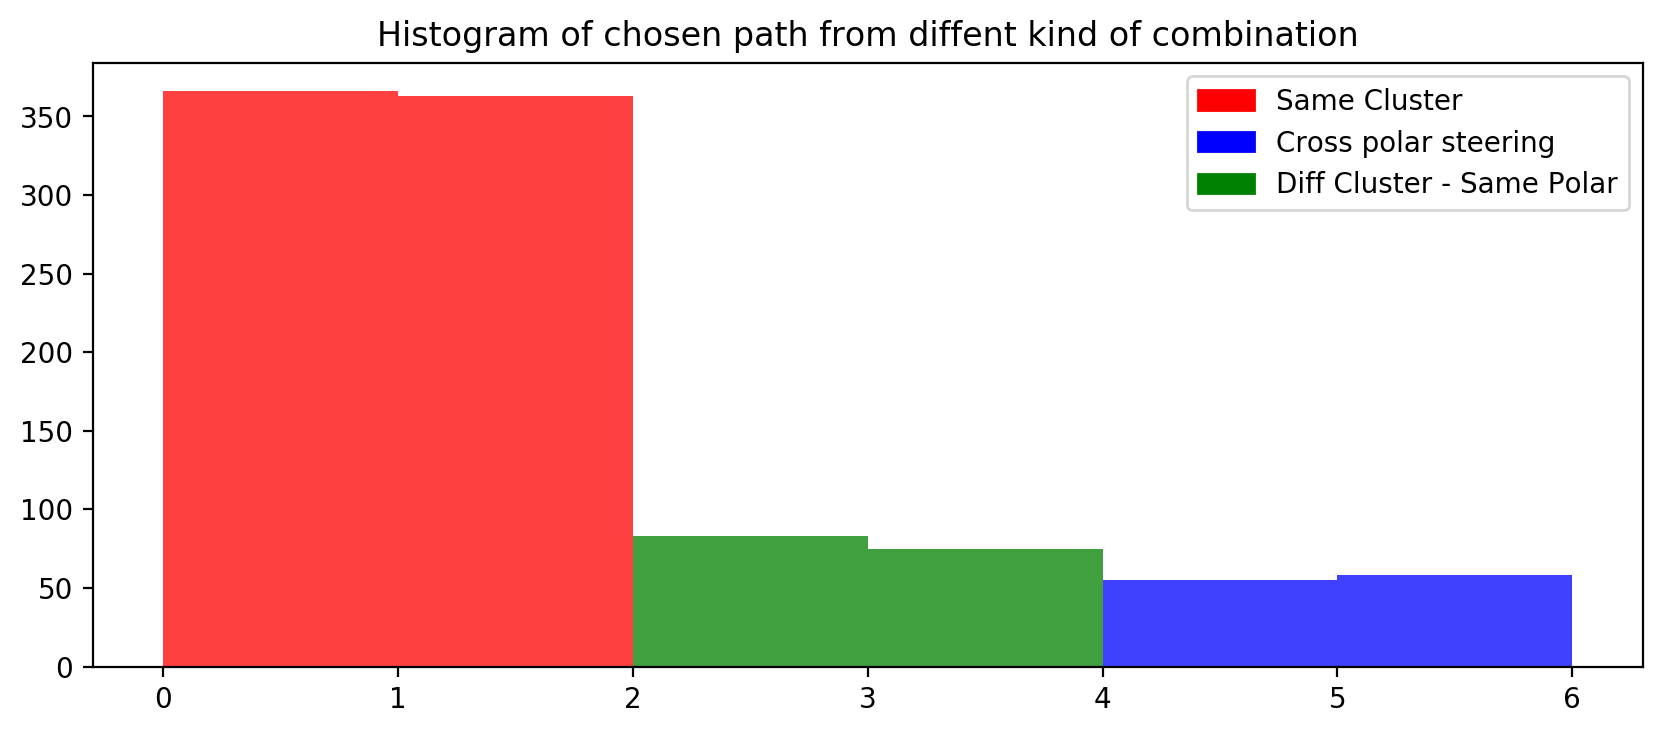

In [15]:
fig = plt.figure(figsize=(10,4), dpi=200)
n, bins, patches = plt.hist(index, bins=range(0,num_path+1),facecolor='green', alpha=0.75)
# ,edgecolor='black'
# print(n.shape)
# print(bins.shape)
# print(n)
# print(bins)

for i in range(0,Nc):
    patches[i].set_fc('r')
for j in cross_index:
    patches[j].set_fc('b')
    
cluster_same = mpatches.Patch(color='red', label='Same Cluster')
cross_polar = mpatches.Patch(color='blue', label='Cross polar steering')
diff_clus_same_polar = mpatches.Patch(color='green', label='Diff Cluster - Same Polar')

plt.legend(handles=[cluster_same,cross_polar,diff_clus_same_polar])
plt.title('Histogram of chosen path from diffent kind of combination')
plt.show()


In [16]:
unique, counts = np.unique(index, return_counts=True)
print(dict(zip(unique, counts)))


{0: 366, 1: 363, 2: 83, 3: 75, 4: 55, 5: 58}


### Distribution of each kind of combination by simulation

__Same Cluster__

In [17]:
index_sameclus = np.zeros(realization,dtype=int)
for reali in range(realization):
    index_sameclus[reali] = np.argmax(path_gain[0:Nc,reali])

In [18]:
gain_sameclus = np.zeros(realization,dtype=float)
for reali in range(realization):
    gain_sameclus[reali] = path_gain[index_sameclus[reali],reali]

__Different Cluster-Cross Polar__

In [19]:
cross_index

array([4, 5])

In [20]:
index_diffclus_crosspol = np.zeros(realization,dtype=int)
for reali in range(realization):
    index_diffclus_crosspol[reali] = np.argmax(path_gain[cross_index,reali])

In [21]:
gain_diffclus_crosspol = np.zeros(realization,dtype=float)
for reali in range(realization):
    gain_diffclus_crosspol[reali] = path_gain[cross_index[np.argmax(path_gain[cross_index,reali])],reali]

__Different Cluster-Same Polar__

In [22]:
samepolar_index

array([2, 3])

In [23]:
index_diffclus_samepol = np.zeros(realization,dtype=int)
for reali in range(realization):
    index_diffclus_samepol[reali] = np.argmax(path_gain[samepolar_index,reali])

In [24]:
gain_diffclus_samepol = np.zeros(realization,dtype=float)
for reali in range(realization):
    gain_diffclus_samepol[reali] = path_gain[samepolar_index[np.argmax(path_gain[samepolar_index,reali])],reali]

__Plot the Distribution__

Average of Same Cluster Gain Distribution: 7.64040525907
Average of Different Cluster - Cross polar Gain Distribution: 2.50180627468
Average of Different Cluster - Same polar Gain Distribution: 2.57390601662


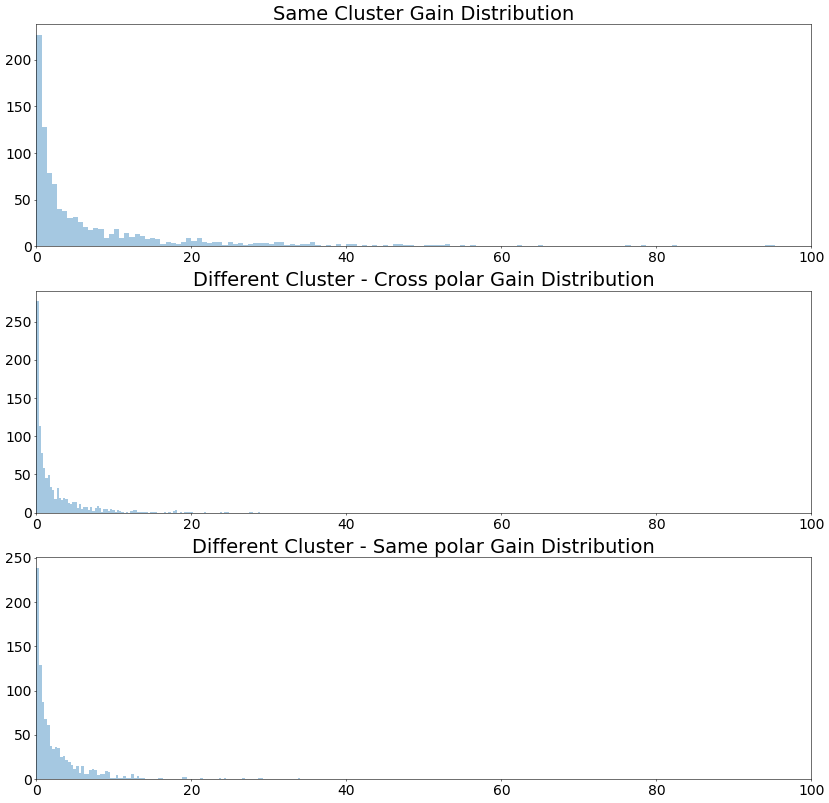

In [25]:
fig = plt.figure(figsize=(20,20), dpi=50)

plt.subplot(3, 1, 1)
plt.title('Same Cluster Gain Distribution', fontsize = 28)
sns.distplot(gain_sameclus,bins=180, kde = False)
plt.xlim(0,100)
plt.tick_params(axis='both', which='major', labelsize=20)
print('Average of Same Cluster Gain Distribution:',np.mean(gain_sameclus))

plt.subplot(3, 1, 2)
plt.title('Different Cluster - Cross polar Gain Distribution', fontsize = 28)
sns.distplot(gain_diffclus_crosspol,bins=100, kde = False)
plt.xlim(0,100)
plt.tick_params(axis='both', which='major', labelsize=20)
print('Average of Different Cluster - Cross polar Gain Distribution:',np.mean(gain_diffclus_crosspol))

plt.subplot(3, 1, 3)
plt.title('Different Cluster - Same polar Gain Distribution', fontsize = 28)
sns.distplot(gain_diffclus_samepol,bins=100, kde = False)
plt.xlim(0,100)
plt.tick_params(axis='both', which='major', labelsize=20)
print('Average of Different Cluster - Same polar Gain Distribution:',np.mean(gain_diffclus_samepol))

Average of Same Cluster Gain Distribution: 5.13859898438
Average of Different Cluster - Cross polar Gain Distribution: 5.06649924244
857
803


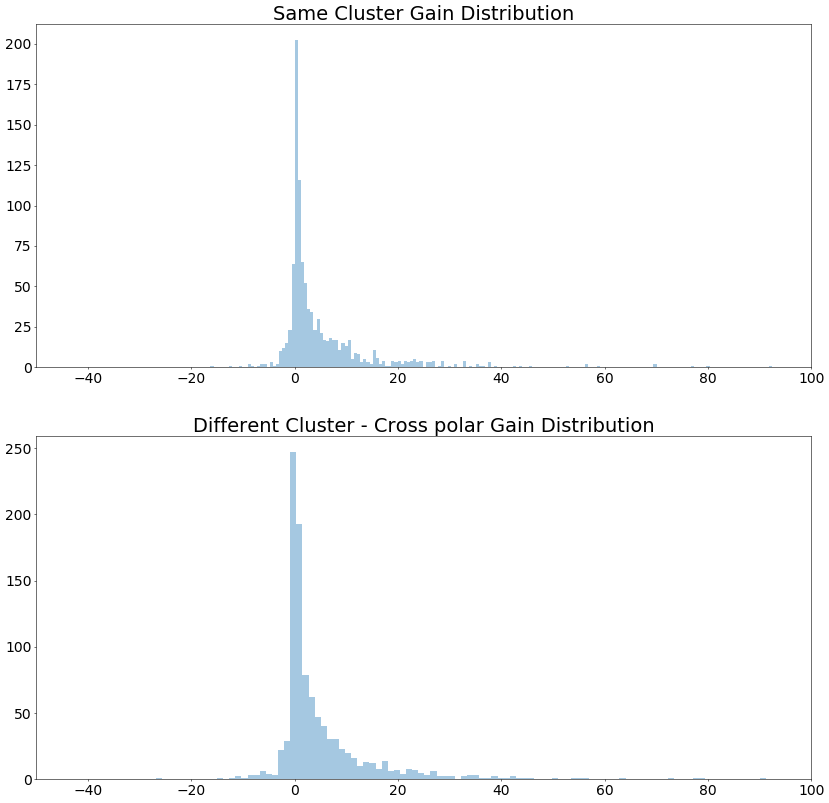

In [26]:
fig = plt.figure(figsize=(20,20), dpi=50)

plt.subplot(2, 1, 1)
plt.title('Same Cluster Gain Distribution', fontsize = 28)
sns.distplot(gain_sameclus-gain_diffclus_crosspol,bins=180, kde = False)
plt.xlim(-50,100)
plt.tick_params(axis='both', which='major', labelsize=20)
print('Average of Same Cluster Gain Distribution:',np.mean(gain_sameclus-gain_diffclus_crosspol))

plt.subplot(2, 1, 2)
plt.title('Different Cluster - Cross polar Gain Distribution', fontsize = 28)
sns.distplot(gain_sameclus-gain_diffclus_samepol,bins=100, kde = False)
plt.xlim(-50,100)
plt.tick_params(axis='both', which='major', labelsize=20)
print('Average of Different Cluster - Cross polar Gain Distribution:',np.mean(gain_sameclus-gain_diffclus_samepol))
print(np.count_nonzero(gain_sameclus>gain_diffclus_crosspol))
print(np.count_nonzero(gain_sameclus>gain_diffclus_samepol))

### Same Cluster Steering

In [27]:
sameclus_path = np.zeros((2,realization),dtype=int)


### Independent Beam Steering Horizontal | Vertical 

In [28]:
steer_path = np.zeros((2,realization),dtype=int)
for reali in range(realization):
    steer_path[0,reali] = np.argmax((np.abs(alpha_hh[:,reali]))**2)
    steer_path[1,reali] = np.argmax((np.abs(alpha_vv[:,reali]))**2)
    

In [30]:
path_combi[index[0]]

array([1, 1, 0, 0])

### Plot Spectral Efficiency

In [31]:
SNR_dB = np.arange(-35,10,5)
SNR = 10**(SNR_dB/10)
smax = SNR.shape[0]
R_cross = np.zeros([smax, realization],dtype=complex)
R_steer = np.zeros([smax, realization],dtype=complex)
R_samecl = np.zeros([smax, realization],dtype=complex)


for reali in range(realization):
    _chosen_combi_path = path_combi[index[reali]]
    _chosen_steer_path = steer_path[:,reali]
    _chosen_sameclus_path = path_combi[index_sameclus[reali]]
    
    W_cross = np.vstack((Ar[:,[_chosen_combi_path[1]],reali],Ar[:,[_chosen_combi_path[3]],reali]))
    F_cross = np.vstack((At[:,[_chosen_combi_path[0]],reali],At[:,[_chosen_combi_path[2]],reali]))
    
    W_steer = np.vstack((Ar[:,[_chosen_steer_path[0]],reali],Ar[:,[_chosen_steer_path[1]],reali]))
    F_steer = np.vstack((At[:,[_chosen_steer_path[0]],reali],At[:,[_chosen_steer_path[1]],reali]))
    
    W_samecl = np.vstack((Ar[:,[_chosen_sameclus_path[1]],reali],Ar[:,[_chosen_sameclus_path[3]],reali]))
    F_samecl = np.vstack((At[:,[_chosen_sameclus_path[0]],reali],At[:,[_chosen_sameclus_path[2]],reali]))
    for s in range(smax):
        R_cross[s,reali] = np.log2(np.linalg.det(np.eye(Ns)+(SNR[s]/Ns)*np.linalg.pinv(W_cross)@H[:,:,reali]@F_cross@F_cross.conj().T@H[:,:,reali].conj().T@W_cross))
        R_steer[s,reali] = np.log2(np.linalg.det(np.eye(Ns)+(SNR[s]/Ns)*np.linalg.pinv(W_steer)@H[:,:,reali]@F_steer@F_steer.conj().T@H[:,:,reali].conj().T@W_steer))
        R_samecl[s,reali] = np.log2(np.linalg.det(np.eye(Ns)+(SNR[s]/Ns)*np.linalg.pinv(W_samecl)@H[:,:,reali]@F_samecl@F_samecl.conj().T@H[:,:,reali].conj().T@W_samecl))

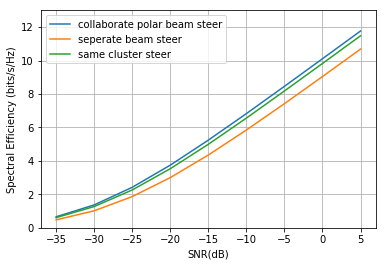

In [32]:
plt.plot(SNR_dB, (np.sum(R_cross,axis=1).real)/realization, label='collaborate polar beam steer')
plt.plot(SNR_dB, (np.sum(R_steer,axis=1).real)/realization, label='seperate beam steer')
plt.plot(SNR_dB, (np.sum(R_samecl,axis=1).real)/realization, label='same cluster steer')

plt.legend(loc='upper left')
plt.xlabel('SNR(dB)')
plt.ylabel('Spectral Efficiency (bits/s/Hz)')
plt.ylim(0,13)
plt.grid()
plt.show()